In [1]:
#Import Relevant Packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs       # ccrs contains information about projections
import cartopy                   # contains all other cartopy functions/classes/methods
import cartopy.feature as cfeature
import os

View pre-processed data, which have been modified to include divergence and vorticity

Divergence equation:
\begin{equation*}
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}
\end{equation*}


Divergent when:
\begin{equation*}
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} > 0
\end{equation*}


Convergent when:
\begin{equation*}
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} < 0
\end{equation*}

Vorticity:
\begin{equation*}
\frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
\end{equation*}



In [2]:
indir='/shared/marn5895/data/GrahamJosieProject/yrly_outputs/'
!ls /shared/marn5895/data/GrahamJosieProject/yrly_outputs/

conv_1992.nc  conv_1998.nc  conv_2004.nc  conv_2010.nc	conv_2016.nc
conv_1993.nc  conv_1999.nc  conv_2005.nc  conv_2011.nc	conv_2017.nc
conv_1994.nc  conv_2000.nc  conv_2006.nc  conv_2012.nc	conv_2018.nc
conv_1995.nc  conv_2001.nc  conv_2007.nc  conv_2013.nc	conv_2019.nc
conv_1996.nc  conv_2002.nc  conv_2008.nc  conv_2014.nc	conv_2020.nc
conv_1997.nc  conv_2003.nc  conv_2009.nc  conv_2015.nc


In [3]:
#open data from all years in 1 xarray object
yrly_data=xr.open_mfdataset(indir+'*.nc', concat_dim='time', drop_variables=['um','vm'])
yrly_data

<xarray.Dataset>
Dimensions:    (longitude: 1201, latitude: 481, time: 29, depth: 1)
Coordinates:
  * longitude  (longitude) float64 20.0 20.33 20.67 21.0 ... 419.3 419.7 420.0
  * latitude   (latitude) float64 80.0 79.67 79.33 79.0 ... -79.33 -79.67 -80.0
  * time       (time) int64 1992 1993 1994 1995 1996 ... 2017 2018 2019 2020
  * depth      (depth) float32 15.0
Data variables:
    u          (time, depth, latitude, longitude) float64 dask.array<chunksize=(1, 1, 481, 1201), meta=np.ndarray>
    v          (time, depth, latitude, longitude) float64 dask.array<chunksize=(1, 1, 481, 1201), meta=np.ndarray>
    dvdy       (time, depth, latitude, longitude) float64 dask.array<chunksize=(1, 1, 481, 1201), meta=np.ndarray>
    dudx       (time, depth, latitude, longitude) float64 dask.array<chunksize=(1, 1, 481, 1201), meta=np.ndarray>
    conv       (time, depth, latitude, longitude) float64 dask.array<chunksize=(1, 1, 481, 1201), meta=np.ndarray>
    vort       (time, depth, latitude, longitude) float64 dask.array<chunksize=(1, 1, 481, 1201), meta=np.ndarray>

In [4]:
#average yearly data across all 29 years
avg_29_yr=yrly_data.mean(dim=('time'))
avg_29_yr=avg_29_yr.drop('depth')
avg_29_yr

<xarray.Dataset>
Dimensions:    (longitude: 1201, latitude: 481, depth: 1)
Coordinates:
  * longitude  (longitude) float64 20.0 20.33 20.67 21.0 ... 419.3 419.7 420.0
  * latitude   (latitude) float64 80.0 79.67 79.33 79.0 ... -79.33 -79.67 -80.0
Dimensions without coordinates: depth
Data variables:
    u          (depth, latitude, longitude) float64 dask.array<chunksize=(1, 481, 1201), meta=np.ndarray>
    v          (depth, latitude, longitude) float64 dask.array<chunksize=(1, 481, 1201), meta=np.ndarray>
    dvdy       (depth, latitude, longitude) float64 dask.array<chunksize=(1, 481, 1201), meta=np.ndarray>
    dudx       (depth, latitude, longitude) float64 dask.array<chunksize=(1, 481, 1201), meta=np.ndarray>
    conv       (depth, latitude, longitude) float64 dask.array<chunksize=(1, 481, 1201), meta=np.ndarray>
    vort       (depth, latitude, longitude) float64 dask.array<chunksize=(1, 481, 1201), meta=np.ndarray>

/home/grt21003/miniconda/envs/marn5895/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


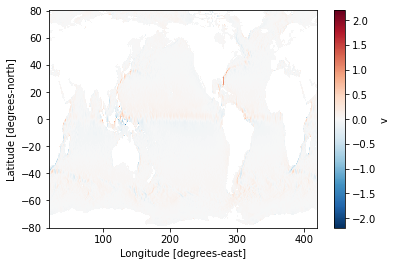

In [5]:
#quick plot of meridional velocity to check plot formatting
avg_29_yr.v.plot()

In [6]:
#function to transition from Oscar's native 20-420 degree longitude range to a more standard 0-360 degree longitude range
def lon_20_420_to_0_360(x):
    #take input xarray dataset and return the same dataset, but with longitude bounds from 0 to 360 degrees
    #adapted from code here:
    #https://stackoverflow.com/questions/53345442/about-changing-longitude-array-from-0-360-to-180-to-180-with-python-xarray
    
    
    x=x.where(x['longitude']<380, drop=True)#remove duplicate data past 360 degrees
    
    lon_name = 'longitude'  #current longitude variable name

    # Adjust lon values to make sure they are within (0,360)
    x['_longitude_adjusted'] = xr.where(
    x[lon_name] > 360,#if this is 180 instead, you get -180 to 180
    x[lon_name] - 360,
    x[lon_name])

    # reassign the new coords to as the main lon coords
    # and sort DataArray using new coordinate values
    x = (
    x
    .swap_dims({lon_name: '_longitude_adjusted'})
    .sel(**{'_longitude_adjusted': sorted(x._longitude_adjusted)})
    .drop(lon_name))

    x = x.rename({'_longitude_adjusted': lon_name})
    
    return(x)
    

/home/grt21003/miniconda/envs/marn5895/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Average Ocean Meridional Velocity (v) between 1992 and 2020 [m/s]')

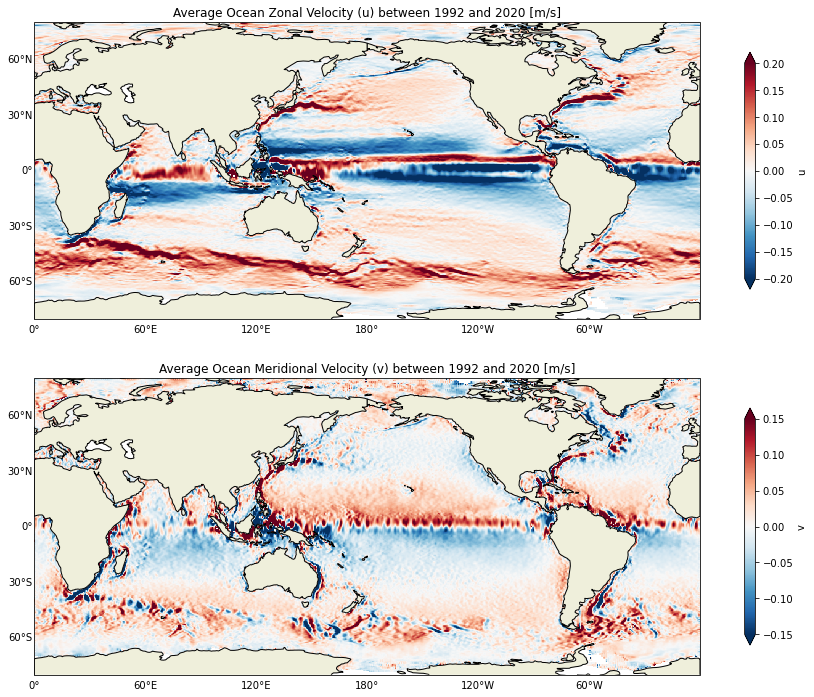

In [7]:
#apply longitude functino to correct longitude coordinates, plot u and v to see if it looks reasonable
avg_29_yr=lon_20_420_to_0_360(avg_29_yr)


fig, axes = plt.subplots( nrows=2,figsize=(16,12), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

axes[0].add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

gl = axes[0].gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color='gray',
    alpha=0,
    linestyle='--'
)
gl.top_labels=False
gl.right_labels=False

axes[1].add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

gl = axes[1].gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color='gray',
    alpha=0,
    linestyle='--'
)
gl.top_labels=False
gl.right_labels=False



cmap='RdBu_r'
avg_29_yr.u[0].plot.pcolormesh(ax=axes[0],
                               transform=ccrs.PlateCarree(),
                               vmin=-0.2,
                               vmax=0.2,
                               cmap=cmap,
                               cbar_kwargs={'shrink':.8})

avg_29_yr.v[0].plot.pcolormesh(ax=axes[1],
                               transform=ccrs.PlateCarree(),
                               vmin=-0.15,
                               vmax=0.15,
                               cmap=cmap,
                               cbar_kwargs={'shrink':.8})

axes[0].set_title('Average Ocean Zonal Velocity (u) between 1992 and 2020 [m/s]')
axes[1].set_title('Average Ocean Meridional Velocity (v) between 1992 and 2020 [m/s]')


/home/grt21003/miniconda/envs/marn5895/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


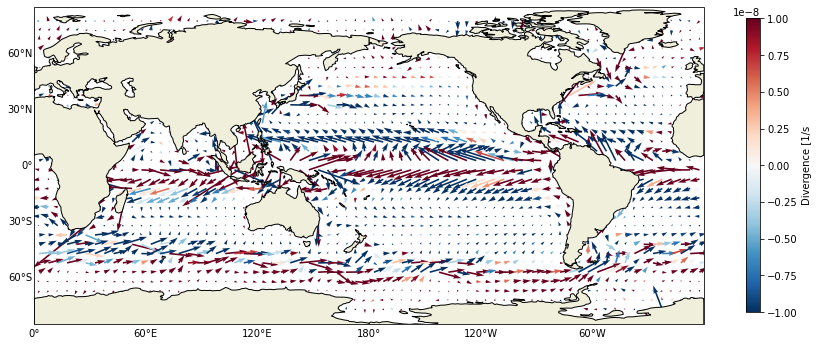

In [8]:
#visualize u and v currents with a quiver plot:
#Quiver plot of Convergence, every 5 degrees
#coarsen data to make arrows space out nicely on quiver plot
qdata=avg_29_yr.coarsen(latitude=15, longitude=15, boundary='trim').mean()

fig, axes = plt.subplots(figsize=(15,9), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axes.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

lon=qdata.longitude.values
lat=qdata.latitude.values

X, Y = np.meshgrid(lon, lat)

U = qdata.u[0].values
V = qdata.v[0].values

kw = {
    'cmap':'RdBu_r',
}

gl = axes.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color='gray',
    alpha=0,
    linestyle='--',
    zorder=0
)
gl.top_labels=False
gl.right_labels=False

quiver=axes.quiver(X,Y,U,V,qdata.conv[0], transform=ccrs.PlateCarree(),**kw)
cb=plt.colorbar(quiver, shrink=0.6, label='Divergence [1/s')
quiver.set_clim(-0.00000001,0.00000001)



Text(0.5, 1.0, 'Average Ocean Divergence between 1992 and 2020')

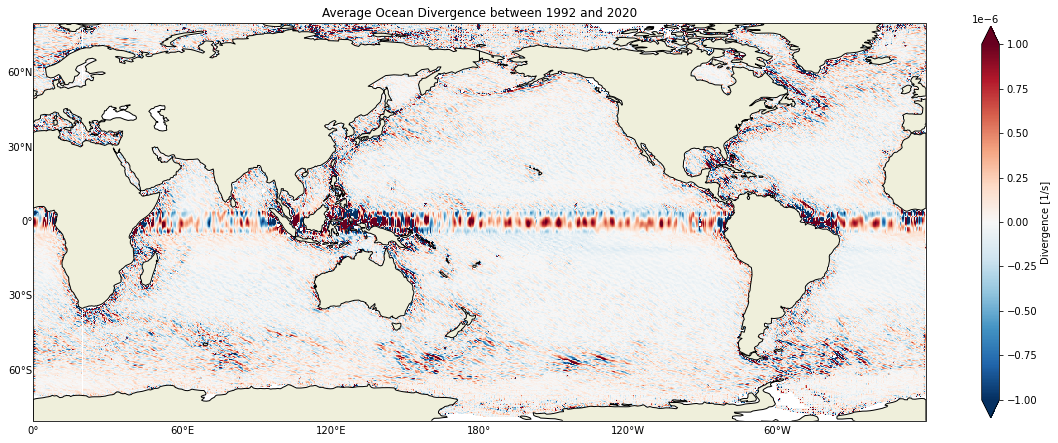

In [9]:
#Now, lets plot divergence/convergence
fig, axes = plt.subplots(figsize=(20,12) ,subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

axes.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

gl = axes.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color='gray',
    alpha=0,
    linestyle='--'
)
gl.top_labels=False
gl.right_labels=False

cmap='RdBu_r'
im=avg_29_yr.conv[0].plot.pcolormesh(ax=axes,
                                     transform=ccrs.PlateCarree(), 
                                     vmin=-0.000001, vmax=0.000001, 
                                     cmap=cmap, 
                                     cbar_kwargs={'label':'Divergence [1/s]', 'shrink':.6} )

axes.set_title('Average Ocean Divergence between 1992 and 2020')


In [11]:
#Now, let's coarsen the resolution of the data to highlight regional divergence/convergenve trends

desired_resolution=2 #resolution in degrees
coarse=avg_29_yr.coarsen(latitude=3*desired_resolution, longitude=3*desired_resolution, boundary='trim').mean()
#check to see if resolution changed
#coarse.longitude

/home/grt21003/miniconda/envs/marn5895/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Average Ocean Divergence between 1992 and 2020')

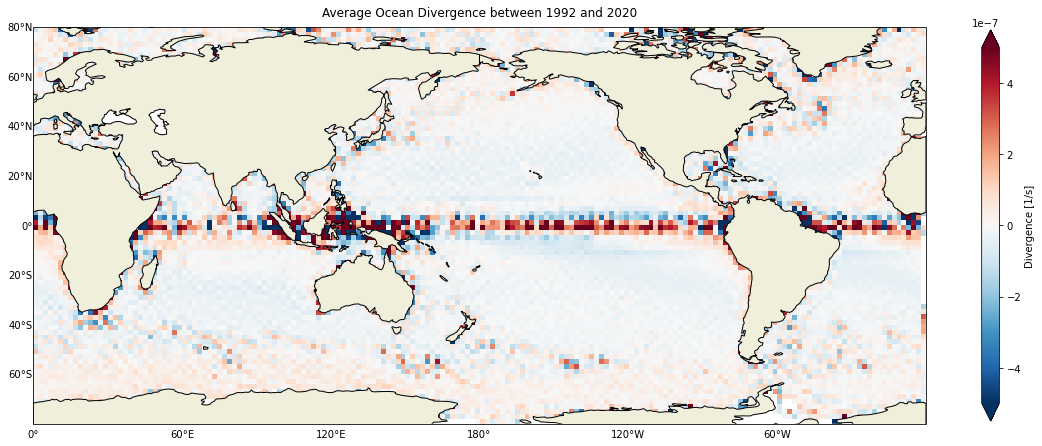

In [12]:
#plot coarsened data and examine regional divergence trends
fig, axes = plt.subplots(figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
#ax = plt.axes(projection=ccrs.PlateCarree())

axes.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

gl = axes.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color='gray',
    alpha=0,
    linestyle='--'
)
gl.top_labels=False
gl.right_labels=False

cmap='RdBu_r'
coarse.conv[0].plot.pcolormesh(ax=axes, 
                               transform=ccrs.PlateCarree(), 
                               vmin=-0.0000005, 
                               vmax=0.0000005, 
                               cmap=cmap, 
                               cbar_kwargs={'label':'Divergence [1/s]', 'shrink':0.6} )

axes.set_title('Average Ocean Divergence between 1992 and 2020')

In [16]:
#finally, compare decades
first_10 = yrly_data.sel(time=slice(1992,2002)).mean(dim='time')
last_10 = yrly_data.sel(time=slice(2010,2020)).mean(dim='time')
first_10_coarse=first_10.coarsen(latitude=3, longitude=3, boundary='trim').mean()
last_10_coarse=last_10.coarsen(latitude=3, longitude=3, boundary='trim').mean()

Diff=last_10_coarse.conv-first_10_coarse.conv

Text(0.5, 1.0, 'Average Ocean Divergence difference between [2010-2020] and [1992-2002]')

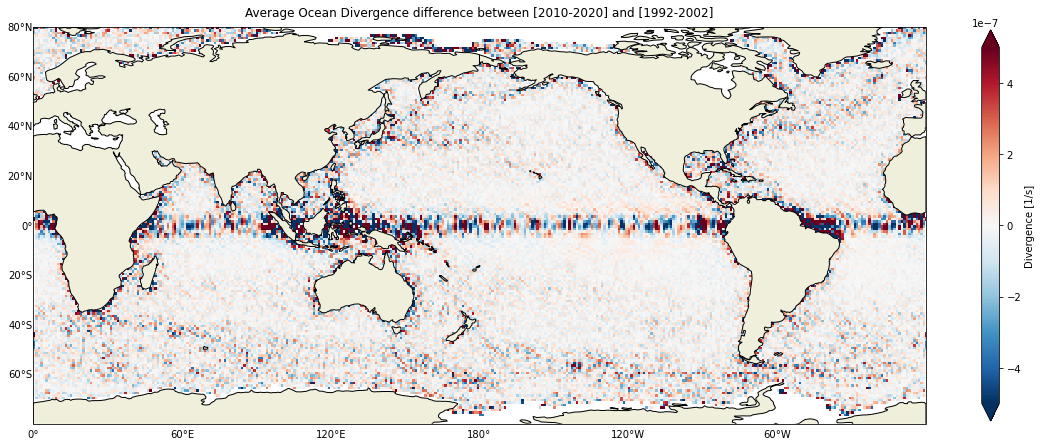

In [29]:
fig, axes = plt.subplots(figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axes.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
gl = axes.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color='gray',
    alpha=0,
    linestyle='--'
)
gl.top_labels=False
gl.right_labels=False
cmap='RdBu_r'
Diff[0].plot.pcolormesh(ax=axes, transform=ccrs.PlateCarree(), vmin=-0.0000005, vmax=0.0000005, cmap=cmap, cbar_kwargs={'label':'Divergence [1/s]', 'shrink':0.6} )

axes.set_title('Average Ocean Divergence difference between [2010-2020] and [1992-2002]')

Text(0.5, 1.0, 'Average Ocean Divergence difference between [2010-2020] and [1992-2002]')

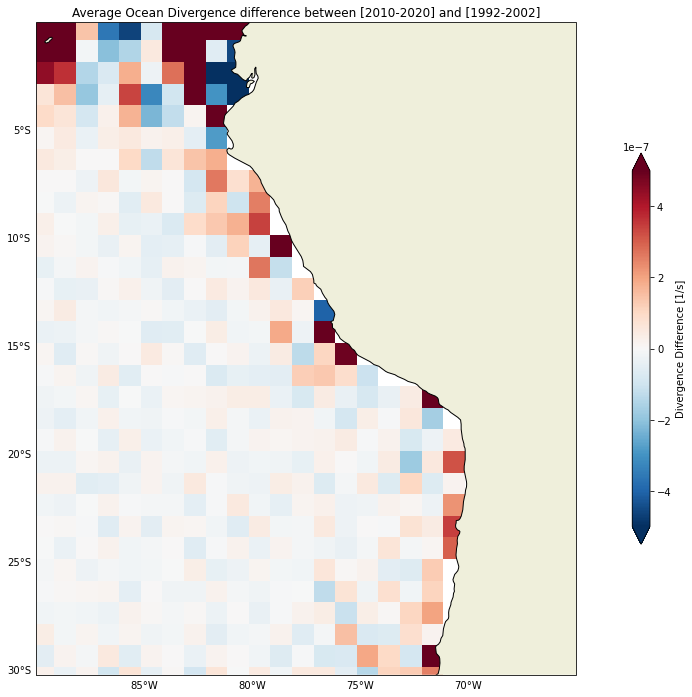

In [31]:
#zoom in on peru
fig, axes = plt.subplots(figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
regional_extent = [-90, -65,0 , -30]
axes.set_extent(regional_extent)
axes.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
gl = axes.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color='gray',
    alpha=0,
    linestyle='--'
)
gl.top_labels=False
gl.right_labels=False
cmap='RdBu_r'
Diff[0].plot.pcolormesh(ax=axes, transform=ccrs.PlateCarree(), vmin=-0.0000005, vmax=0.0000005, cmap=cmap, cbar_kwargs={'label':'Divergence Difference [1/s]', 'shrink':0.6} )
axes.set_title('Average Ocean Divergence difference between [2010-2020] and [1992-2002]')